In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

### Hyperparameters


In [2]:
pre_trained = "bert-base-german-cased"
#pre_trained = "smanjil/German-MedBERT"
epochs = 18
batch_size = 36
drop_out = 0.2
learning_rate = 3e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  
dataset['Text'] = dataset['Text'].astype(str)


In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=False)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='micro')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.4010872162878514
Validation loss: 1.1143881870854286
F1 Score (Weighted): 0.5836330935251799


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9395361699163913
Validation loss: 1.0421441158940714
F1 Score (Weighted): 0.6348920863309353


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6786620173603296
Validation loss: 1.0815007100182195
F1 Score (Weighted): 0.658273381294964


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4366433059796691
Validation loss: 1.2049408814599436
F1 Score (Weighted): 0.6528776978417267


Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.32876492720097306
Validation loss: 1.3297132474760855
F1 Score (Weighted): 0.6528776978417267


Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.20750675285235048
Validation loss: 1.3824241891984017
F1 Score (Weighted): 0.6600719424460432


Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.167406713985838
Validation loss: 1.4842573115902562
F1 Score (Weighted): 0.6510791366906474


Epoch 8:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.12036096716765314
Validation loss: 1.5587491546907732
F1 Score (Weighted): 0.6654676258992805


Epoch 9:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.08098405640339479
Validation loss: 1.7498105110660676
F1 Score (Weighted): 0.6519784172661871


Epoch 10:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.08057728811400011
Validation loss: 1.771630887062319
F1 Score (Weighted): 0.6681654676258992


Epoch 11:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.04844963317445945
Validation loss: 1.9298458830002816
F1 Score (Weighted): 0.6609712230215827


Epoch 12:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.02743396202567965
Validation loss: 2.0458236202116935
F1 Score (Weighted): 0.6600719424460432


Epoch 13:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.030194114745245314
Validation loss: 2.1088437149601598
F1 Score (Weighted): 0.6663669064748201


Epoch 14:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.01764704180532135
Validation loss: 2.1435348333850985
F1 Score (Weighted): 0.6591726618705036


Epoch 15:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.017214624711778016
Validation loss: 2.1993676327889964
F1 Score (Weighted): 0.6609712230215827


Epoch 16:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.016891984177345876
Validation loss: 2.2074471827476256
F1 Score (Weighted): 0.6627697841726619


Epoch 17:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.012081917433533818
Validation loss: 2.23611125446135
F1 Score (Weighted): 0.6627697841726619


Epoch 18:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.006048605922842398
Validation loss: 2.2334289531553946
F1 Score (Weighted): 0.6654676258992805


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((i+1, accuracy))
print(total_acc)

[(1, 0.5836330935251799), (2, 0.6348920863309353), (3, 0.658273381294964), (4, 0.6528776978417267), (5, 0.6528776978417267), (6, 0.6600719424460432), (7, 0.6510791366906474), (8, 0.6654676258992805), (9, 0.6519784172661871), (10, 0.6681654676258992), (11, 0.6609712230215827), (12, 0.6600719424460432), (13, 0.6663669064748201), (14, 0.6591726618705036), (15, 0.6609712230215827), (16, 0.6627697841726619), (17, 0.6627697841726619), (18, 0.6654676258992805)]


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

Class: -
Accuracy: 152/251

Class: MH
Accuracy: 14/63

Class: D
Accuracy: 148/202

Class: TP
Accuracy: 206/262

Class: S
Accuracy: 69/149

Class: DP
Accuracy: 60/185

Class: -
Accuracy: 159/251

Class: MH
Accuracy: 33/63

Class: D
Accuracy: 143/202

Class: TP
Accuracy: 216/262

Class: S
Accuracy: 66/149

Class: DP
Accuracy: 89/185

Class: -
Accuracy: 158/251

Class: MH
Accuracy: 37/63

Class: D
Accuracy: 139/202

Class: TP
Accuracy: 210/262

Class: S
Accuracy: 96/149

Class: DP
Accuracy: 92/185

Class: -
Accuracy: 161/251

Class: MH
Accuracy: 36/63

Class: D
Accuracy: 143/202

Class: TP
Accuracy: 197/262

Class: S
Accuracy: 74/149

Class: DP
Accuracy: 115/185

Class: -
Accuracy: 154/251

Class: MH
Accuracy: 36/63

Class: D
Accuracy: 142/202

Class: TP
Accuracy: 200/262

Class: S
Accuracy: 107/149

Class: DP
Accuracy: 87/185

Class: -
Accuracy: 183/251

Class: MH
Accuracy: 31/63

Class: D
Accuracy: 136/202

Class: TP
Accuracy: 190/262

Class: S
Accuracy: 79/149

Class: DP
Accuracy: 115/

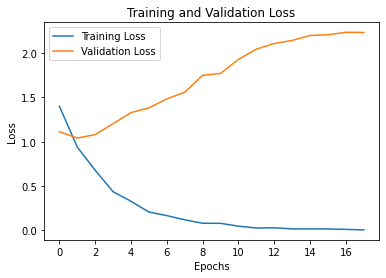

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()